In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib

# ---------------------------
# Load data
# ---------------------------
data = pd.read_csv(r"Sample - Superstore.csv", encoding='latin1')



In [23]:
# ---------------------------
#  Exploar the Data
# ---------------------------
data.describe()
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [24]:
# ---------------------------
# Data Preprocessing
# ---------------------------
# Remove outliers
data = data[(data['Profit'] > data['Profit'].quantile(0.01)) &
            (data['Profit'] < data['Profit'].quantile(0.99))]

# Convert to datetime
data["Order Date"] = pd.to_datetime(data["Order Date"])
data["Ship Date"] = pd.to_datetime(data["Ship Date"])

# Extract features
data["Order_Year"] = data["Order Date"].dt.year
data["Order_Month"] = data["Order Date"].dt.month
data["Order_Day"] = data["Order Date"].dt.day
data["Order_DayOfWeek"] = data["Order Date"].dt.dayofweek
data["Order_Quarter"] = data["Order Date"].dt.quarter
data["Shipping_Days"] = (data["Ship Date"] - data["Order Date"]).dt.days

# Cyclical encoding
data["Month_sin"] = np.sin(2 * np.pi * data["Order_Month"] / 12)
data["Month_cos"] = np.cos(2 * np.pi * data["Order_Month"] / 12)
data["DayOfWeek_sin"] = np.sin(2 * np.pi * data["Order_DayOfWeek"] / 7)
data["DayOfWeek_cos"] = np.cos(2 * np.pi * data["Order_DayOfWeek"] / 7)

# Drop unused columns
data = data.drop(['Row ID', 'Order ID', 'Customer ID', 'Customer Name',
                  'Postal Code', 'Product ID'], axis=1)


# ---------------------------
# Features & Target
# ---------------------------
y = data["Profit"]
X = data.drop(["Profit", "Order Date", "Ship Date"], axis=1)

# ---------------------------
# Define numeric and categorical features
# ---------------------------
numeric_features = ["Sales","Quantity","Discount",
                    "Order_Year","Order_Month","Order_Day",
                    "Order_DayOfWeek","Order_Quarter","Shipping_Days",
                    "Month_sin","Month_cos","DayOfWeek_sin","DayOfWeek_cos"]

categorical_features = ["Category","Sub-Category","Country","Region",
                        "Ship Mode","Segment","State","City","Product Name"]

# ---------------------------
# Preprocessing Pipeline
# ---------------------------
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


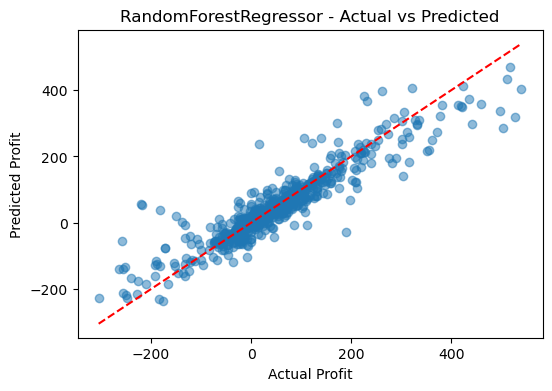

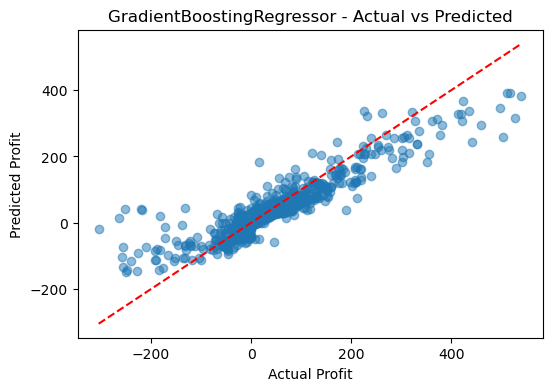

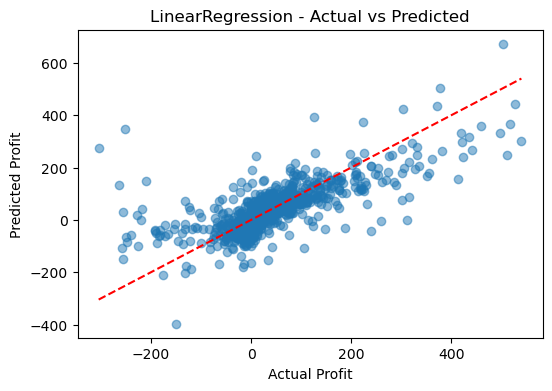

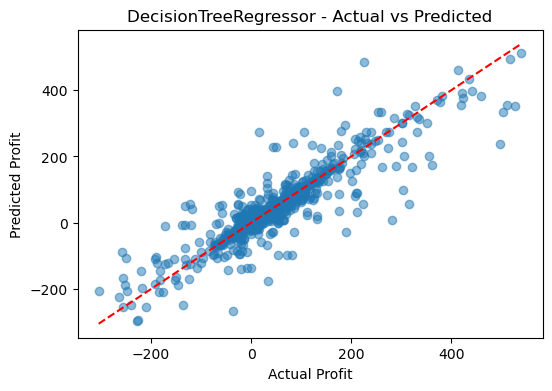

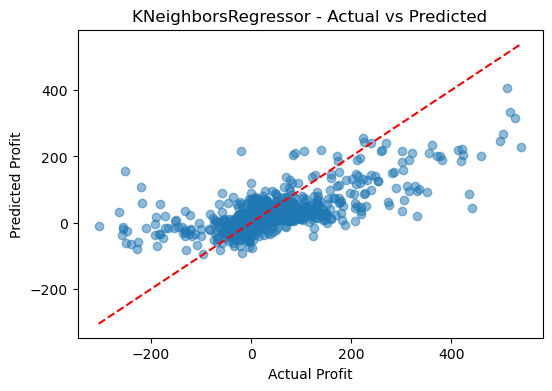

                       Model  Train R2   Test R2        MAE       RMSE
0      RandomForestRegressor  0.977039  0.860728  11.030024  27.553600
1  GradientBoostingRegressor  0.847980  0.814015  15.690256  31.840883
3      DecisionTreeRegressor  1.000000  0.804884  12.336111  32.613127
2           LinearRegression  0.779533  0.505958  29.657551  51.895337
4        KNeighborsRegressor  0.629459  0.464144  29.907860  54.046863


In [25]:
# ---------------------------
# Models to test
# ---------------------------
models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "KNeighborsRegressor": KNeighborsRegressor()
}

results = []

# ---------------------------
# Train + Evaluate
# ---------------------------
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(x_train, y_train)

    y_pred_train = pipe.predict(x_train)
    y_pred_test = pipe.predict(x_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    results.append({
        "Model": name,
        "Train R2": train_r2,
        "Test R2": test_r2,
        "MAE": mae,
        "RMSE": rmse
    })

    # Visualization
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.xlabel("Actual Profit")
    plt.ylabel("Predicted Profit")
    plt.title(f"{name} - Actual vs Predicted")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()

# ---------------------------
# Results
# ---------------------------
results_data = pd.DataFrame(results)
print(results_data.sort_values(by="Test R2", ascending=False))

In [ ]:
# ---------------------------
# Save Best Model
# ---------------------------
best_model_name = results_data.sort_values(by="Test R2", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

final_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", best_model)])
final_pipeline.fit(X, y)

joblib.dump(final_pipeline, "super_store_pipeline_new.pkl")
print(f"Best model saved: {best_model_name}")